In [3]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "99"

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1351692816775365409]

In [4]:
tf.Session()

# If you have gpu you can try this line to compute b with your GPU
#with tf.device('/gpu:0'): 
with tf.device('/cpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])   
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print(sess.run(c))

# Runs the op.
# Log information
options = tf.RunOptions(output_partition_graphs=True)
metadata = tf.RunMetadata()
c_val = sess.run(c, options=options, run_metadata=metadata)

print(metadata.partition_graphs)

sess.close()

[[22. 28.]
 [49. 64.]]
[node {
  name: "_retval_MatMul_0_0"
  op: "_Retval"
  input: "MatMul/_0__cf__0"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "index"
    value {
      i: 0
    }
  }
  experimental_debug_info {
    original_node_names: "_retval_MatMul_0_0"
  }
}
node {
  name: "MatMul/_0__cf__0"
  op: "Const"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 2
          }
          dim {
            size: 2
          }
        }
        tensor_content: "\000\000\260A\000\000\340A\000\000DB\000\000\200B"
      }
    }
  }
}
library {
}
versions {
  producer: 27
}
]


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#set verbosity to INFO level
tf.logging.set_verbosity(tf.logging.INFO)

sess = tf.InteractiveSession()

train = pd.read_csv('dataset/train.csv')
print('Shape of the train data with all features:', train.shape)
train = train.select_dtypes(exclude=['object'])
print('Shape of the train data with numerical features:', train.shape)
#fix missing values
train.fillna(0,inplace=True)
#drop Id column
train.drop('Id',axis = 1, inplace = True)

print("")

test = pd.read_csv('dataset/test.csv')
print('Shape of the test data with all features:', test.shape)
test = test.select_dtypes(exclude=['object'])
print('Shape of the test data with numerical features:', test.shape)
#fix missing values
test.fillna(0,inplace=True)
#drop Id column
ID = test.Id
test.drop('Id',axis = 1, inplace = True)

print("")
print("List of features contained our dataset:",list(train.columns))

Shape of the train data with all features: (1460, 81)
Shape of the train data with numerical features: (1460, 38)

Shape of the test data with all features: (1459, 80)
Shape of the test data with numerical features: (1459, 37)

List of features contained our dataset: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


/Users/armin/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [8]:
#Detecting outliers
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

/Users/armin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:214: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/armin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/armin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Number of Outliers: 146
Number of rows without outliers: 1314


In [9]:
train.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
5,50,85.0,14115,5,5,1993,1995,0.0,732,0,...,40,30,0,320,0,0,700,10,2009,143000
6,20,75.0,10084,8,5,2004,2005,186.0,1369,0,...,255,57,0,0,0,0,0,8,2007,307000
7,50,51.0,6120,7,5,1931,1950,0.0,0,0,...,90,0,205,0,0,0,0,4,2008,129900
8,190,50.0,7420,5,6,1939,1950,0.0,851,0,...,0,4,0,0,0,0,0,1,2008,118000
9,20,70.0,11200,5,5,1965,1965,0.0,906,0,...,0,0,0,0,0,0,0,2,2008,129500


In [11]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)
col_train_bis.remove('SalePrice')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('SalePrice',axis = 1))
mat_y = np.array(train.SalePrice).reshape((1314,1))

#not used!
mms_y = MinMaxScaler()
mms_y.fit(mat_y)

mms = MinMaxScaler()
mms.fit(mat_train)

mms_test = MinMaxScaler()
mms_test.fit(mat_new)

train = pd.DataFrame(mms.transform(mat_train),columns = col_train)
test  = pd.DataFrame(mms_test.transform(mat_test),columns = col_train_bis)

train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.235294,0.207668,0.062802,0.625,0.428571,0.953488,0.883333,0.12250,0.416274,0.0,...,0.000000,0.167582,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.403057
1,0.000000,0.255591,0.072904,0.500,0.857143,0.744186,0.433333,0.00000,0.576651,0.0,...,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.340220
2,0.235294,0.217252,0.087396,0.625,0.428571,0.937984,0.866667,0.10125,0.286557,0.0,...,0.000000,0.115385,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.437966
3,0.294118,0.191693,0.072464,0.625,0.428571,0.271318,0.333333,0.00000,0.127358,0.0,...,0.000000,0.096154,0.824242,0.0,0.0,0.0,0.0,0.090909,0.00,0.243639
4,0.235294,0.268371,0.113835,0.750,0.428571,0.930233,0.833333,0.21875,0.386203,0.0,...,0.260870,0.230769,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.499638


In [13]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)

# Training for submission
training_sub = training_set[col_train]

training_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1200,0.058824,0.488818,0.024752,0.250,0.285714,0.472868,0.000000,0.00,0.000000,0.0,...,0.000000,0.054945,0.0,0.000000,0.0,0.0,0.0,0.181818,0.00,0.040003
1134,0.235294,0.000000,0.205377,0.500,0.428571,0.922481,0.816667,0.00,0.000000,0.0,...,0.000000,0.282967,0.0,0.000000,0.0,0.0,0.0,0.454545,0.75,0.339057
826,0.000000,0.207668,0.078499,0.500,0.428571,0.968992,0.933333,0.00,0.016509,0.0,...,0.135870,0.000000,0.0,0.045276,0.0,0.0,0.0,0.818182,0.00,0.313434
1308,0.000000,0.287540,0.139808,0.375,0.428571,0.976744,0.933333,0.00,0.000000,0.0,...,0.048913,0.153846,0.0,0.000000,0.0,0.0,0.0,0.545455,0.00,0.114476
617,0.588235,0.194888,0.055134,0.500,0.428571,0.968992,0.933333,0.16,0.011792,0.0,...,0.260870,0.076923,0.0,0.000000,0.0,0.0,0.0,0.454545,0.25,0.370940


In [14]:
# Same thing but for the test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1232,0.235294,0.239617,0.074221,0.625,0.571429,0.914729,0.800000,0.00000,0.574882,0.0,...,0.343750,0.467033,0.0,0.0,0.0,0.0,0.000000,0.454545,0.00,0.556191
76,0.352941,0.000000,0.063505,0.625,0.428571,0.891473,0.766667,0.01375,0.000000,0.0,...,0.163043,0.197802,0.0,0.0,0.0,0.0,0.045161,0.363636,0.75,0.309966
962,0.176471,0.159744,0.055205,0.375,0.142857,0.527132,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.636364,0.00,0.130767
433,0.588235,0.102236,0.028107,0.500,0.428571,0.914729,0.800000,0.07250,0.528892,0.0,...,0.000000,0.343407,0.0,0.0,0.0,0.0,0.000000,0.363636,0.00,0.299493
1110,0.823529,0.115016,0.011665,0.625,0.428571,0.953488,0.883333,0.06625,0.000000,0.0,...,0.000000,0.074176,0.0,0.0,0.0,0.0,0.000000,0.454545,1.00,0.326257


In [15]:
# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])#,
                                         #optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))

In [16]:
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

In [17]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [18]:
# Deep Neural Network Regressor with the training set which contain the data split by train test split
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0xb261cc128>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column

In [19]:
# Evaluation on the test set created by train_test_split
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [20]:
# Display the score on the testing set
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 0.002665


In [22]:
import itertools

# Predictions
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

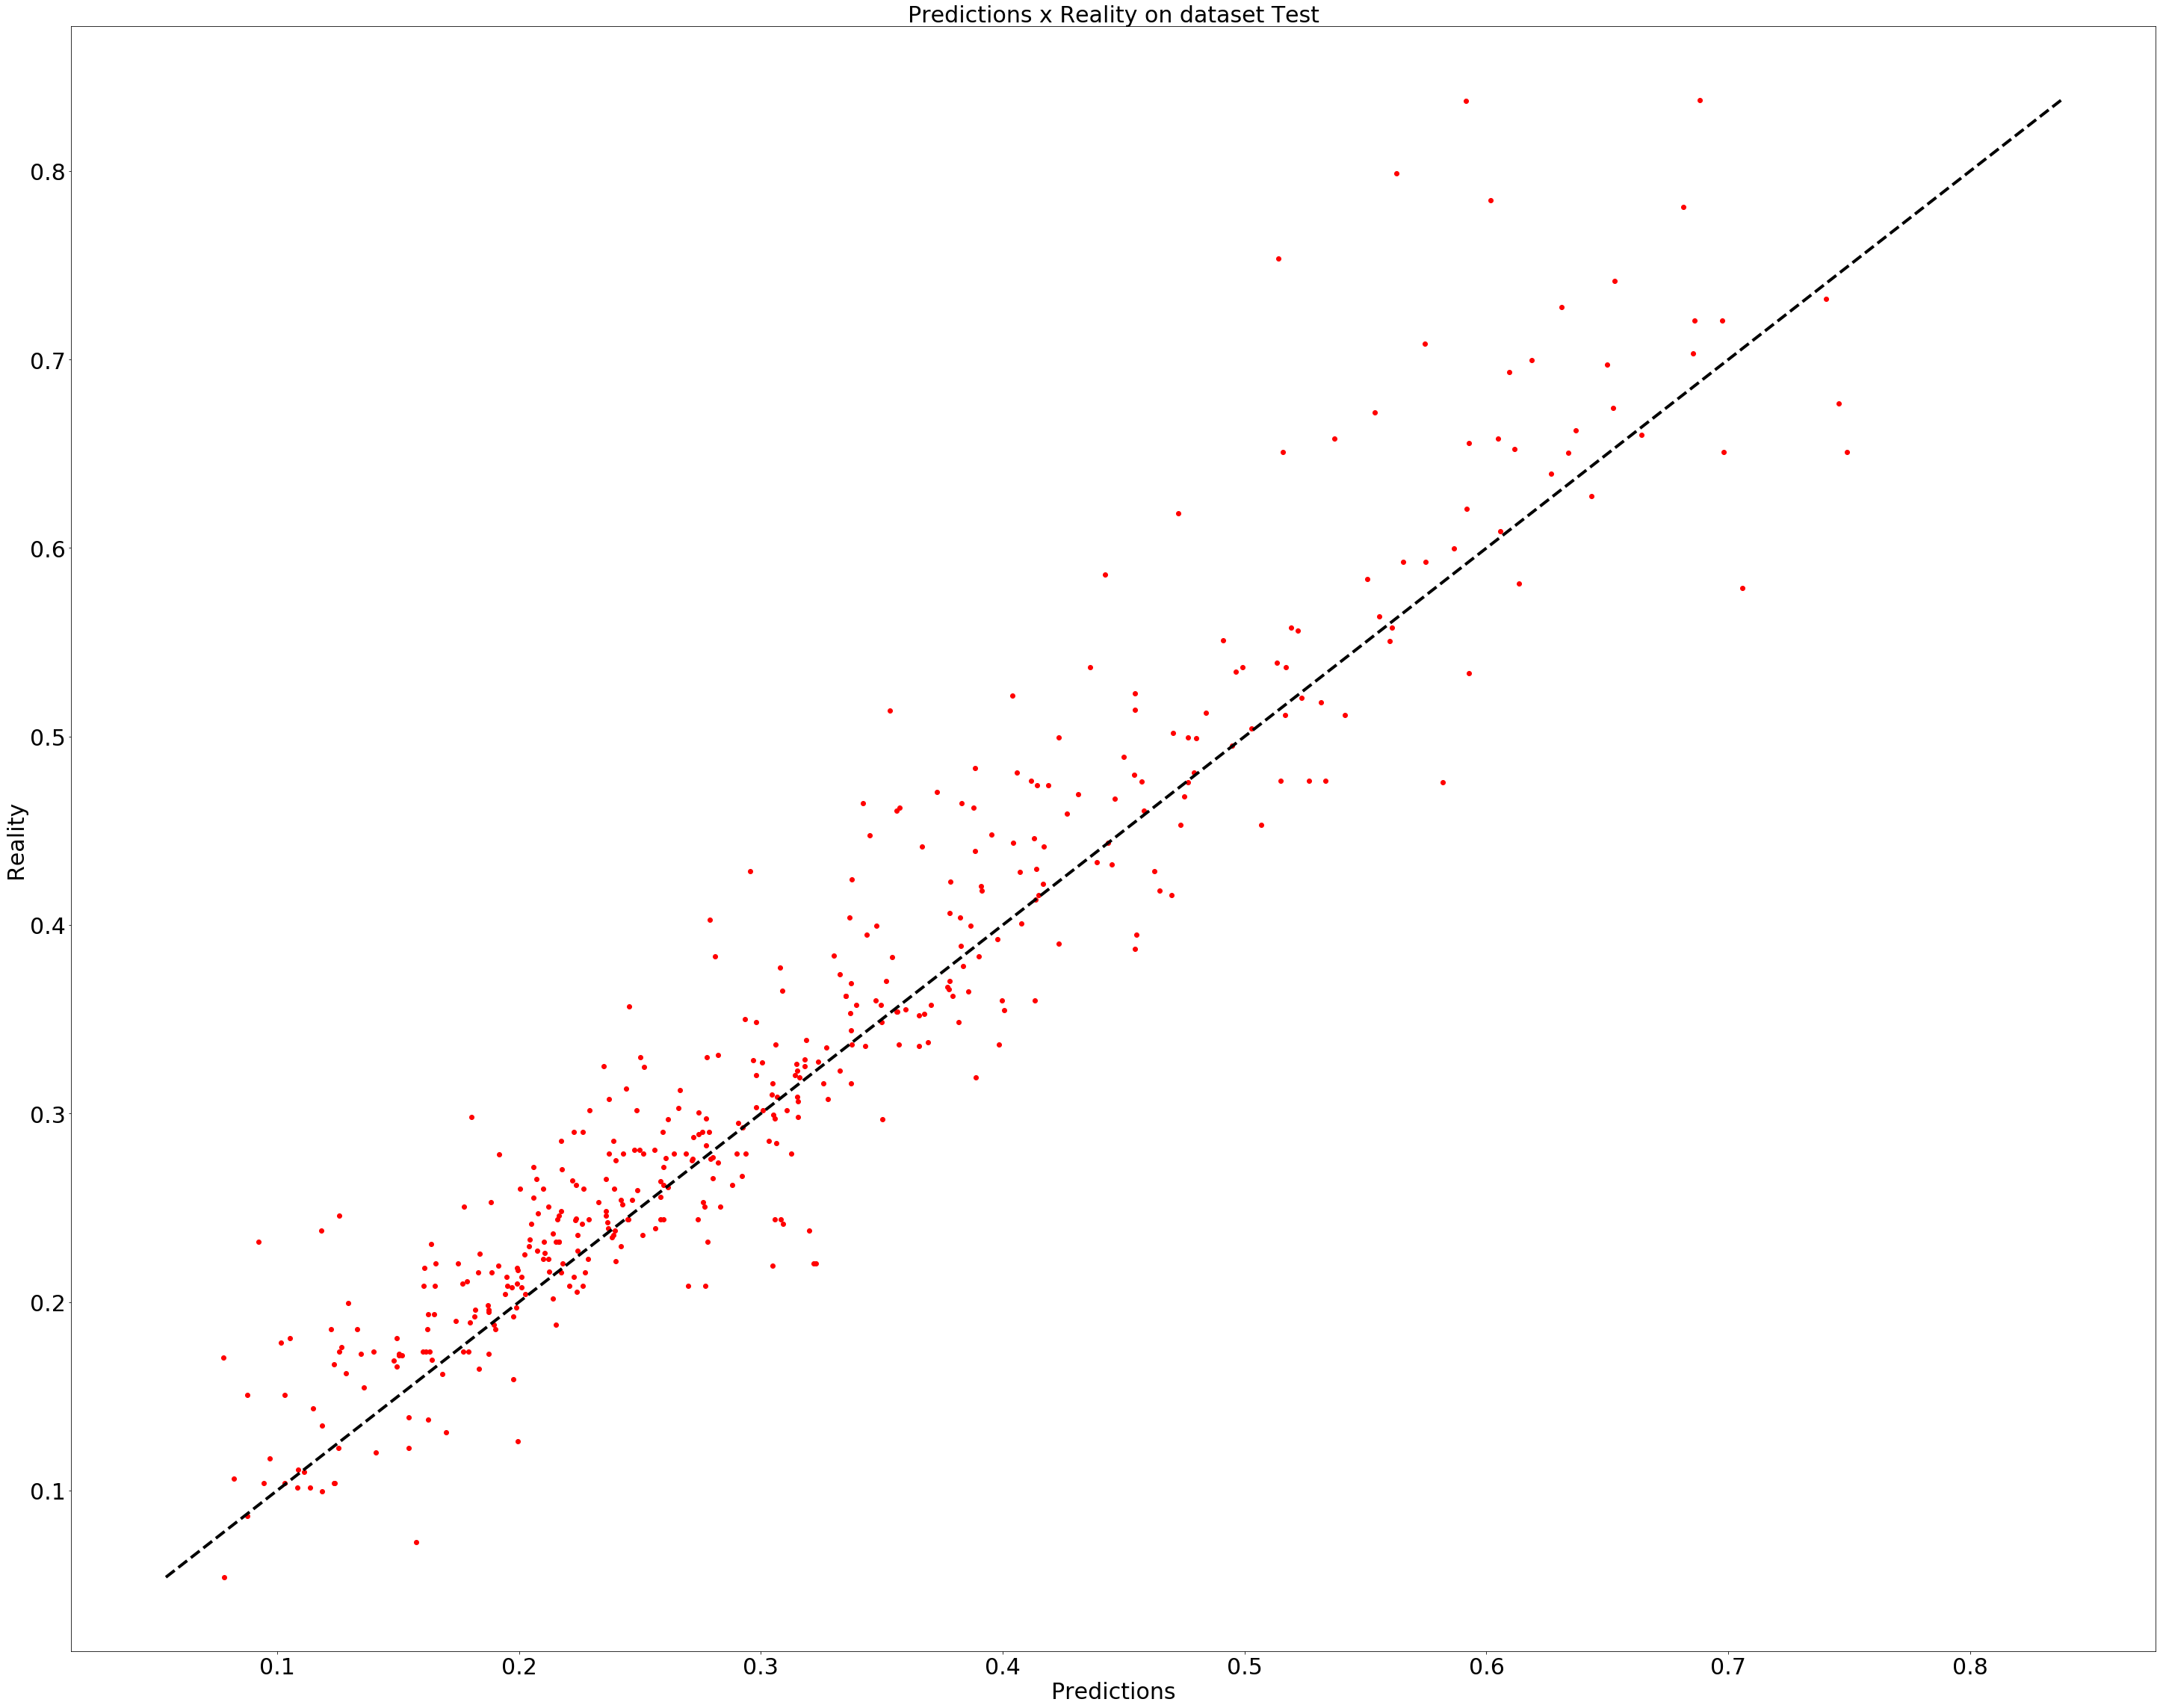

In [24]:
predictions = pd.DataFrame(mms_y.inverse_transform(np.array(predictions).reshape(434,1)),columns = ['Prediction'])
reality = pd.DataFrame(mms.inverse_transform(testing_set), columns = [COLUMNS]).SalePrice

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()

In [26]:
y_predict = regressor.predict(input_fn=lambda: input_fn(test, pred = True))

def to_submit(pred_y,name_out):
    y_predict = list(itertools.islice(pred_y, test.shape[0]))
    y_predict = pd.DataFrame(mms_y.inverse_transform(np.array(y_predict).reshape(len(y_predict),1)), columns = ['SalePrice'])
    y_predict = y_predict.join(ID)
    y_predict.to_csv(name_out + '.csv',index=False)
    
to_submit(y_predict, "submission_continuous")

In [27]:
def leaky_relu(x):
    return tf.nn.relu(x) - 0.01 * tf.nn.relu(-x)